elapsed time 측정하기
interpretable model 생성하기

feature map 별로 가중치 계산, 레시피 별로 다른 양상이 나타나는가??

weighted average pooling
weighted? -> attention score를 이용하자.

해석력? CAM, grad-CAM, attention 자체 등 여러 가지가 있을 것!

데이터셋 여러 개 구비가능한가?
plasma on/off??

plasma all_on
plasma 1_on
plasma all_off

In [41]:
import numpy as np
import time
import sys
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [23]:
torch.cuda.set_device(device=0)

In [24]:
# from model import *
# from util import *
# from training import *

In [25]:
def load_X(recipe_no, step_no):
    X_name = './rawdata/RECIPE{}_STEP{:02}.csv'.format(recipe_no, step_no)
    return np.genfromtxt(X_name, delimiter=',', dtype=np.float32)


def load_y(recipe_no):
    y_name = './rawdata/RECIPE{}_fault.csv'.format(recipe_no)
    return np.genfromtxt(y_name, delimiter=',', dtype=np.int32)

In [26]:
def load_data_cat_nan(recipe_no, step_no_list=[10, 11, 12, 13, 14], 
                      preprocessing=None, scale=True, split=True,
                      trn_size=0.6, val_size=0.2, random_state=0):
    # fault -> array
    y = load_y(recipe_no)
    X_list = []
    # step 10~14까지 가져오기
    for step_no in step_no_list:
        X = load_X(recipe_no, step_no).T
        print(step_no, X.shape[1]/65)
        X_list.append(X)

    n_data = X_list[0].shape[0]
    maxlen = sum([X.shape[1] for X in X_list])
    
    print('maxlen : {}'.format(maxlen))
    
    row_list = []
    len_list = []
    for i in range(n_data):
        rows = [X[i] for X in X_list]
        rows = [x[~np.isnan(x)] for x in rows]
        row = np.concatenate(rows)
        len_list.append(len(row))
        row = np.pad(row, (0, maxlen - len(row)), 'constant') 
        row_list.append(row)
    X = np.stack(row_list)
    print(X.shape, y.shape)
    len_list = np.array(len_list) / 65
    
    if preprocessing is not None:
        X = preprocessing(X)
    
    if split is True:
        tst_size = 1. - trn_size - val_size
        X_trn, X_tst, y_trn, y_tst, l_trn, l_tst = train_test_split(
            X, y, len_list, test_size=tst_size, random_state=random_state, stratify=y)

        val_size = val_size / (val_size + trn_size)
        X_trn, X_val, y_trn, y_val, l_trn, l_val = train_test_split(
            X_trn, y_trn, l_trn, test_size=val_size, random_state=random_state, stratify=y_trn)

        if scale is True:
            scaler = StandardScaler()
            scaler.fit(X_trn)
            X_trn = scaler.transform(X_trn)
            X_val = scaler.transform(X_val)
            X_tst = scaler.transform(X_tst)

        return X_trn, X_val, X_tst, y_trn, y_val, y_tst, l_trn, l_val, l_tst

    else:
        return X, y, len_list

In [10]:
def model_hyperparameter(batch_size = 64, n_epoch = 200, learning_rate = 0.005, 
                     max_tol = 50, regularizer = 0, model_type = 'yeop', kfold = 3, 
                     random_state = 0, verbose = True, encoding_kernel = 10, 
                     attn_kernel = 120, pos_ratio = 0.1) :
    hyper =  dict()
    hyper['batch_size'] = batch_size
    hyper['n_epoch'] = n_epoch
    hyper['learning_rate'] = learning_rate
    hyper['max_tol'] = max_tol
    hyper['regularizer'] = regularizer
    hyper['model_type'] = model_type
    hyper['kfold'] = kfold
    hyper['random_state'] = random_state
    hyper['verbose'] = verbose
    hyper['pos_ratio'] = pos_ratio
    if model_type == 'yeop' :
        hyper['encoding_kernel'] = encoding_kernel
        hyper['attn_kernel'] = attn_kernel
    
    return hyper

In [11]:
#### model_hyperparameter -> argparse로 변경하기 #####
step_list = list(range(10,17))
model_hyperparameter = model_hyperparameter()
num_workers = 1
save_path = './multitask/'

In [12]:
recipe_no = 1
X1, y1, l1 = load_data_cat_nan(recipe_no, step_list,# 14, 15],
                            preprocessing=None, split=False, scale=False)

10 15.0
11 15.0
12 20.0
13 20.0
14 60.0
15 100.0
16 90.0
maxlen : 20800
(778, 20800) (778,)


In [13]:
recipe_no = 2
X2, y2, l2 = load_data_cat_nan(recipe_no, step_list,# 14, 15],
                            preprocessing=None, split=False, scale=False)

10 15.0
11 15.0
12 20.0
13 20.0
14 60.0
15 100.0
16 90.0
maxlen : 20800
(1546, 20800) (1546,)


In [27]:
def sampling(maxlen, recipe_data) :
    len_ = recipe_data.shape[0]
    plus_choice = np.random.choice(recipe_data, maxlen - len_)
    return np.concatenate([recipe_data, plus_choice])

In [37]:
def resample_data(X, y, i=None, pos_ratio=0.2):
    # i : 길이
    # pos_idx : 아웃라이어
    pos_idx = np.where(y==1)[0]
    neg_idx = np.where(y==0)[0]
    
    # 정상 * (정상:비정상 비)
    n_new_pos = int(len(neg_idx) * pos_ratio / (1 - pos_ratio))
    np.random.seed(0)
    # 오버샘플링
    new_pos_idx = np.random.choice(pos_idx, n_new_pos)
    
    X = np.concatenate([X[new_pos_idx], X[neg_idx]], axis=0)
    y = np.concatenate([y[new_pos_idx], y[neg_idx]], axis=0)
    if i is not None:
        i = np.concatenate([i[new_pos_idx], i[neg_idx]], axis=0)
        return X, y, i
    return X, y

In [28]:
class MyVarDataSet(Dataset):
    def __init__(self, X, y, recipe_no):
        X = self.preprocessing(X)        
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).long()
        self.recipe_no = recipe_no

    def preprocessing(self, X): # (timelen * max_features, n_data)
        max_features = 65
        n_data = X.shape[0]
        timelen = int(X.shape[1] / max_features)

        X = X.reshape(n_data, timelen, max_features)
        return X

    def __getitem__(self, index):
        if type(self.recipe_no) is int :
            self.recipe_no = np.array([self.recipe_no for i in range(len(self.X))])
            self.recipe_no = torch.from_numpy(self.recipe_no).long()
        return self.X[index], self.y[index], self.recipe_no[index]

    def __len__(self):
        return len(self.X)

In [29]:
class MultiTaskYeopNet(nn.Module) :
    def __init__(self, encoding_kernel, attn_kernel):
        super(MultiTaskYeopNet, self).__init__()
        self.kernel = encoding_kernel
        self.hidden = attn_kernel
        
        # time-series encoding
        self.conv = nn.Conv2d(1, self.kernel, (65,3), bias = False)
        
        # convolution attention 
        self.attn_conv = nn.Conv2d(1, self.hidden, (self.kernel, 1), bias = False) # bias 지우기
        self.dropout = nn.Dropout2d(p=0.5)
        self.fc_recipe1_1 = nn.Linear(self.kernel * self.hidden, 128)
        self.fc_recipe1_2 = nn.Linear(128, 128)
        self.fc_recipe1_3 = nn.Linear(128, 2)
        
        self.fc_recipe2_1 = nn.Linear(self.kernel * self.hidden, 128)
        self.fc_recipe2_2 = nn.Linear(128, 128)
        self.fc_recipe2_3 = nn.Linear(128, 2)
        
    def forward(self, x, num):
        ## Embedding ##
        batch, time, variable = x.size()
        x = x.view(-1,1,variable,time)
        x = F.tanh(self.conv(x))
        x = torch.transpose(x, 1,2)
        original_x = x
        x = self.attn_conv(x)
        x = F.softmax(x, dim = -1)
        x = self.dropout(x)
        
        x = torch.squeeze(x, dim = 2)
        x = torch.transpose(x, 1,2)
        original_x = torch.squeeze(original_x, dim = 1)
        output = torch.bmm(original_x, x)
        output = torch.flatten(output, start_dim=1)
        
        self.fc_recipe1_1.weight.requires_grad=True
        self.fc_recipe1_2.weight.requires_grad=True
        self.fc_recipe1_3.weight.requires_grad=True
        self.fc_recipe2_1.weight.requires_grad=True
        self.fc_recipe2_2.weight.requires_grad=True
        self.fc_recipe2_3.weight.requires_grad=True
        if num == 1 :
            ## Recipe1 Network ##
            self.fc_recipe2_1.weight.requires_grad=False
            self.fc_recipe2_2.weight.requires_grad=False
            self.fc_recipe2_3.weight.requires_grad=False
            
            output = F.relu(self.fc_recipe1_1(output))
            output = F.relu(self.fc_recipe1_2(output))
            output = self.fc_recipe1_3(output)
        else :
            ## Recipe2 Network ##
            self.fc_recipe1_1.weight.requires_grad=False
            self.fc_recipe1_2.weight.requires_grad=False
            self.fc_recipe1_3.weight.requires_grad=False
            output = F.relu(self.fc_recipe2_1(output))
            output = F.relu(self.fc_recipe2_2(output))
            output = self.fc_recipe2_3(output)
        return F.log_softmax(output, dim=1)

In [39]:
class YeopNet(nn.Module) :
    def __init__(self, encoding_kernel, attn_kernel):
        super(YeopNet, self).__init__()
        self.kernel = encoding_kernel
        self.hidden = attn_kernel
        self.conv = nn.Conv2d(1, self.kernel, (65,3), bias = False)
        #########
        self.conv_1_1 = nn.Conv2d(self.kernel, self.kernel, (1,1), bias = False)
        self.attn_conv = nn.Conv2d(1, self.hidden, (self.kernel, 1), bias = False) # bias 지우기
        self.dropout = nn.Dropout2d(p=0.1)
        self.fc1 = nn.Linear(self.kernel * self.hidden, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
        
    def forward(self, x, lengths):
        ## Embedding ##
        batch, time, variable = x.size()
        x = x.view(-1,1,variable,time)
        x = F.tanh(self.conv(x))
        x = F.tanh(self.conv_1_1(x))
        x = torch.transpose(x, 1,2)
        original_x = x
        x = self.attn_conv(x)
        x = F.softmax(x, dim = -1)
        x = self.dropout(x) # dropout 위치
        
        x = torch.squeeze(x, dim = 2)
        x = torch.transpose(x, 1,2)
        original_x = torch.squeeze(original_x, dim = 1)
        output = torch.bmm(original_x, x)
        output = torch.flatten(output, start_dim=1)
        
        ## Network ##
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return F.log_softmax(output, dim=1)

In [30]:
from sklearn.metrics import roc_auc_score
class Metric() :
    def __init__(self) :
        self.initialize()
        self.result = {}
        self.result['total'] = 0
        self.result['TP'] = 0
        self.result['TN'] = 0
        self.result['FP'] = 0
        self.result['FN'] = 0
        self.result['label'] = []
        self.result['pred'] = []
        
    def initialize(self) :
        self.total = 0
        self.true_pos = 0
        self.false_pos = 0
        self.false_neg = 0
        self.true_neg = 0
        self.label_list = []
        self.pred_list = []
        
    def measure_metric(self, label, pred) :
        pred_ = pred
        pred = pred.max(1)[1]
        self.label_list += label.cpu().data.tolist()
        self.pred_list += pred_.cpu().data.tolist()
        self.total += label.size()[0]
        self.true_pos += torch.sum(pred * label).item()
        self.false_pos += torch.sum(F.relu(pred - label)).item()
        self.false_neg += torch.sum(F.relu(label - pred)).item()
        self.true_neg = (self.total - self.true_pos - self.false_neg - self.false_pos)
        #print(self.total, self.true_pos, self.false_pos, self.false_neg, self.true_neg)
        
    def get_metric(self) :
        accuracy = (self.result['TP'] + self.result['TN']) / self.result['total'] * 100
        
        if (self.result['TP'] + self.result['FP']) == 0 :
            precision = 0.0
        else :
            precision = self.result['TP'] / (self.result['TP'] + self.result['FP']) *100
        if (self.result['TP'] + self.result['FN']) == 0 :
            recall = 0.0
        else :
            recall = self.result['TP'] / (self.result['TP'] + self.result['FN']) * 100 
        if (precision + recall) == 0:
            F1 = 0.0
        else :
            F1 = 2 * precision * recall / (precision + recall)
            
        pred = [row[1] for row in self.result['pred']]
        AUC = roc_auc_score(self.result['label'], pred)
        
        return accuracy, precision, recall, F1, AUC
    
    def save_metric(self) :
        self.result['total'] += self.total
        self.result['TP'] += self.true_pos
        self.result['TN'] += self.true_neg
        self.result['FP'] += self.false_pos
        self.result['FN'] += self.false_neg
        self.result['label'] += self.label_list
        self.result['pred'] += self.pred_list
        

In [35]:
for i in range(n_cv) :
    print()
    print(i+1)
    start_time = time.time()
    cv = StratifiedKFold(n_splits=kfold, random_state=random_state)
    recipe1_trn = [trn for trn, tst in cv.split(X1,y1)]
    recipe1_tst = [tst for trn, tst in cv.split(X1,y1)]
    recipe2_trn = [trn for trn, tst in cv.split(X2,y2)]
    recipe2_tst = [tst for trn, tst in cv.split(X2,y2)]
    
    metric1 = Metric()
    metric2 = Metric()
    
    for j in range(kfold) :
        print('\nkfold', j+1)
        
        len1 = y1[recipe1_tst[j]].shape[0]
        len2 = y2[recipe2_tst[j]].shape[0]
        
        dataset_tst1 = MyVarDataSet(X1[recipe1_tst[j]], y1[recipe1_tst[j]], 1)
        dataset_tst2 = MyVarDataSet(X2[recipe2_tst[j]], y2[recipe2_tst[j]], 2)
        
        
        
        dataloader_tst1 = DataLoader(dataset=dataset_tst1, 
                                    batch_size=len(dataset_tst1), 
                                    shuffle=False, 
                                    num_workers=num_workers)
        
        dataloader_tst2 = DataLoader(dataset=dataset_tst2, 
                                    batch_size=len(dataset_tst2), 
                                    shuffle=False, 
                                    num_workers=num_workers)
        
        print(len(dataset_tst1))


1

kfold 1
260

kfold 2
259

kfold 3
259

2

kfold 1
260

kfold 2
259

kfold 3
259

3

kfold 1
260

kfold 2
259

kfold 3
259

4

kfold 1
260

kfold 2
259

kfold 3
259

5

kfold 1
260

kfold 2
259

kfold 3
259

6

kfold 1
260

kfold 2
259

kfold 3
259

7

kfold 1
260

kfold 2
259

kfold 3
259

8

kfold 1
260

kfold 2
259

kfold 3
259

9

kfold 1
260

kfold 2
259

kfold 3
259

10

kfold 1
260

kfold 2
259

kfold 3
259

11

kfold 1
260

kfold 2
259

kfold 3
259

12

kfold 1
260

kfold 2
259

kfold 3
259

13

kfold 1
260

kfold 2
259

kfold 3
259

14

kfold 1
260

kfold 2
259

kfold 3
259

15

kfold 1
260

kfold 2
259

kfold 3
259

16

kfold 1
260

kfold 2
259

kfold 3
259

17

kfold 1
260

kfold 2
259

kfold 3
259

18

kfold 1
260

kfold 2
259

kfold 3
259

19

kfold 1
260

kfold 2
259

kfold 3
259

20

kfold 1
260

kfold 2
259

kfold 3
259


In [42]:
kfold = model_hyperparameter['kfold']
random_state = model_hyperparameter['random_state']
batch_size = model_hyperparameter['batch_size']
model_type = 'yeop' # model_hyperparameter['model_type']
encoding_kernel = 10 # model_hyperparameter['encoding_kernel'] # 16
attn_kernel = 10 # model_hyperparameter['attn_kernel'] # 128
# learning_rate = 0.0001# model_hyperparameter['learning_rate'] # 0.0001
n_epoch = 200 # model_hyperparameter['n_epoch']
verbose = model_hyperparameter['verbose']
max_tol = model_hyperparameter['max_tol']
n_cv = 20


learning_rate = 0.0001
step_size = 30
gamma = 0.8


recipe1_true_label = []
recipe1_predict_label = []
recipe2_true_label = []
recipe2_predict_label = []

for i in range(n_cv) :
    print()
    print(i+1)
    start_time = time.time()
    cv = StratifiedKFold(n_splits=kfold, random_state=random_state)
    recipe1_trn = [trn for trn, tst in cv.split(X1,y1)]
    recipe1_tst = [tst for trn, tst in cv.split(X1,y1)]
    recipe2_trn = [trn for trn, tst in cv.split(X2,y2)]
    recipe2_tst = [tst for trn, tst in cv.split(X2,y2)]
    
    metric1 = Metric()
    metric2 = Metric()
    
    for j in range(kfold) :
        print('\nkfold', j+1)
        
        len1 = recipe1_trn[j].shape[0]
        len2 = recipe2_trn[j].shape[0]
        max_len = len1 if len1 > len2 else len2
        recipe1_trn[j] = sampling(max_len, recipe1_trn[j])
        recipe2_trn[j] = sampling(max_len, recipe2_trn[j])
        
        
        X1_trn = X1[recipe1_trn[j]]
        y1_trn = y1[recipe1_trn[j]]
        X1_trn, y1_trn = resample_data(X1_trn, y1_trn, pos_ratio=0.1)
        
        scaler1 = StandardScaler()
        scaler1.fit(X1_trn)
        X1_trn = scaler1.transform(X1_trn)
        num1 = np.ones([y1_trn.size])
        
        X2_trn = X2[recipe2_trn[j]]
        y2_trn = y2[recipe2_trn[j]]
        X2_trn, y2_trn = resample_data(X2_trn, y2_trn, pos_ratio=0.1)
        
        scaler2 = StandardScaler()
        scaler2.fit(X2_trn)
        X2_trn = scaler2.transform(X2_trn)
        num2 = np.ones([y2_trn.size]) + 1
        
        dataset_trn1 = MyVarDataSet(X1_trn, y1_trn, num1)
        dataset_trn2 = MyVarDataSet(X2_trn, y2_trn, num2)
        
        dataset_tst1 = MyVarDataSet(X1[recipe1_tst[j]], y1[recipe1_tst[j]], 1)
        dataset_tst2 = MyVarDataSet(X2[recipe2_tst[j]], y2[recipe2_tst[j]], 2)
        
        dataloader_trn1 = DataLoader(dataset=dataset_trn1, 
                                    batch_size=batch_size, 
                                    shuffle=True, 
                                    num_workers=num_workers)
        
        dataloader_trn2 = DataLoader(dataset=dataset_trn2, 
                                    batch_size=batch_size, 
                                    shuffle=True, 
                                    num_workers=num_workers)
        
        dataloader_tst1 = DataLoader(dataset=dataset_tst1, 
                                    batch_size=len(dataset_tst1), 
                                    shuffle=False, 
                                    num_workers=num_workers)
        
        dataloader_tst2 = DataLoader(dataset=dataset_tst2, 
                                    batch_size=len(dataset_tst2), 
                                    shuffle=False, 
                                    num_workers=num_workers)

        
        global_loss = float("inf")
        n_tol = 0

        model = dict(
            yeop = MultiTaskYeopNet(encoding_kernel, attn_kernel),
            solo = YeopNet(encoding_kernel, attn_kernel)
        )[model_type].cuda()
        update = 0
        
        optimizer1 = torch.optim.Adam(model.parameters(), lr=learning_rate)
        optimizer2 = torch.optim.Adam(model.parameters(), lr=learning_rate)

        scheduler1 = StepLR(optimizer1, step_size=step_size, gamma=gamma)
        scheduler2 = StepLR(optimizer2, step_size=step_size, gamma=gamma)
        for epoch in range(1, n_epoch+1):
            metric1.initialize()
            metric2.initialize()
            iter1 = iter(dataloader_trn1)
            iter2 = iter(dataloader_trn2)
            temp_loss = 0.0

            for ii in range(len(dataloader_trn1)):
                # get the inputs
                
                try :
                    optimizer1.zero_grad()

                    data1 = next(iter1)
                    data1 = [d.cuda() for d in data1]
                    pred1 = model(data1[0], 1)
                    cost_penalty= torch.FloatTensor([1,2]).cuda()
                    loss = F.nll_loss(pred1, data1[1])
                    loss.backward()
                    optimizer1.step()

                    optimizer2.zero_grad()

                    data2 = next(iter2)
                    data2 = [d.cuda() for d in data2]
                    pred2 = model(data2[0], 2)
                    loss = F.nll_loss(pred2, data2[1], weight = cost_penalty)
                    loss.backward()
                    optimizer2.step()
                    
                    pred = torch.cat([pred1,pred2])
                    data_ = torch.cat([data1[1], data2[1]])
                    
                    
                    
                except StopIteration:
                    break
            
            
            for i, data in enumerate(dataloader_tst1):
                model.eval()
                data[0] = scaler1.transform(data[0].view(data[0].size()[0], -1))
                data[0] = torch.tensor(data[0].reshape(data[0].shape[0],-1,65), 
                                       dtype=torch.float)
                data = [d.cuda() for d in data]
                pred = model(data[0], 1)   # one-hot
                loss = F.nll_loss(pred, data[1]) # integer
                temp_loss += loss
                metric1.measure_metric(data[1], torch.exp(pred))
                
            for i, data in enumerate(dataloader_tst2):
                model.eval()
                data[0] = scaler2.transform(data[0].view(data[0].size()[0], -1))
                data[0] = torch.tensor(data[0].reshape(data[0].shape[0],-1,65), 
                                       dtype=torch.float)
                data = [d.cuda() for d in data]
                pred = model(data[0], 2)
                loss = F.nll_loss(pred, data[1])
                temp_loss += 1.5*loss
                metric2.measure_metric(data[1], pred)

            
            #############################################################
            epoch_loss = temp_loss/(len(dataloader_tst1) + len(dataloader_tst2))
            #print('%.4f, %.4f'%(epoch_loss.item(), global_loss))
            model.train()
            scheduler1.step()
            scheduler2.step()
            if  epoch_loss < global_loss:
                if verbose:
                    update += 1
                    print('\r==> test loss decreased! {:.4f} --> {:.4f}, update : {:3d}, epoch : {:3d}'
                          .format(global_loss, epoch_loss, update, epoch), end='')
                    sys.stdout.flush()
                    global_loss = epoch_loss
                    
                n_tol = 0


            else:
                n_tol += 1
                if n_tol >=max_tol: 
                    
                    
                    break
            
        metric1.save_metric()
        metric2.save_metric()
        
        for i, data in enumerate(dataloader_tst1):
            model.eval()
            data[0] = scaler1.transform(data[0].view(data[0].size()[0], -1))
            data[0] = torch.tensor(data[0].reshape(data[0].shape[0],-1,65), 
                                   dtype=torch.float)
            data = [d.cuda() for d in data]
            pred = model(data[0], 1)   # one-hot
            pred, data[1]

            recipe1_true_label.append(data1[1].cpu().numpy().tolist())
            recipe1_predict_label.append(np.exp(pred1.cpu().detach().numpy()).tolist())


        for i, data in enumerate(dataloader_tst2):
            model.eval()  
            data[0] = scaler2.transform(data[0].view(data[0].size()[0], -1))
            data[0] = torch.tensor(data[0].reshape(data[0].shape[0],-1,65), 
                                   dtype=torch.float)
            data = [d.cuda() for d in data]
            pred = model(data[0], 1)   # one-hot
            pred, data[1]

            recipe2_true_label.append(data2[1].cpu().numpy().tolist())
            recipe2_predict_label.append(np.exp(pred2.cpu().detach().numpy()).tolist())
        
        
    print()
    print()
    acc, prec, recall, F1, AUC = metric1.get_metric()
    print('recipe1 : Acc : %.2f, Prec : %.2f, Rec : %.2f, F1 : %.2f, AUC : %.4f'%
         (acc, prec, recall, F1, AUC))
    acc, prec, recall, F1, AUC = metric2.get_metric()
    print('recipe2 : Acc : %.2f, Prec : %.2f, Rec : %.2f, F1 : %.2f, AUC : %.4f'%
         (acc, prec, recall, F1, AUC))
    break


1

kfold 1
==> test loss decreased! 0.1597 --> 0.1590, update :  35, epoch :  38

KeyboardInterrupt: 

In [59]:
df = pd.DataFrame(columns = ['1_true', '1_pred', '2_true', '2_pred'])

NameError: name 'pd' is not defined

In [85]:
sum_ =  ([-1] * (len(recipe2_true_label) - len(recipe1_true_label)))

In [88]:
df['2_true'] = recipe2_true_label
df['2_pred'] = recipe2_predict_label
df['1_true'] = (recipe1_true_label + sum_)
df['1_pred'] = (recipe1_predict_label + sum_)


In [89]:
df.to_csv('total.csv')

In [ ]:
recipe1_true_label
recipe1_predict_label
recipe2_true_label
recipe2_predict_label

In [104]:
len(recipe1_true_label[0])

26

In [105]:
len(recipe1_true_label[1])

28

In [106]:
len(recipe1_true_label[2])

19

In [107]:
recipe1_true_label = sum(recipe1_true_label, [])
recipe1_predict_label = sum(recipe1_predict_label, [])
recipe2_true_label = sum(recipe2_true_label, [])
recipe2_predict_label = sum(recipe2_predict_label, [])

In [123]:
for num in range(len(recipe1_predict_label)) :
    print(recipe1_true_label[num], recipe1_predict_label[num])

0 [0.9772077798843384, 0.022792255505919456]
0 [1.0, 2.339513131832671e-12]
0 [0.9999585747718811, 4.159620948485099e-05]
0 [0.9999303817749023, 6.958046287763864e-05]
0 [0.951930046081543, 0.04806991294026375]
0 [0.9834314584732056, 0.016568489372730255]
0 [0.9999485611915588, 5.136255276738666e-05]
0 [1.0, 8.460885637939786e-12]
0 [0.99063640832901, 0.009363732300698757]
0 [0.9995816349983215, 0.0004182742559351027]
0 [1.0, 2.553401379223885e-10]
0 [1.0, 1.0074392875480953e-08]
0 [0.999792754650116, 0.00020712004334200174]
1 [0.3350076377391815, 0.6649923920631409]
0 [1.0, 3.482970023505061e-10]
0 [0.988182783126831, 0.011817285791039467]
0 [0.999090313911438, 0.0009096076828427613]
0 [1.0, 6.454121959098558e-12]
0 [1.0, 3.968718964575402e-10]
0 [0.999997079372406, 2.7494631922309054e-06]
0 [0.9996185898780823, 0.00038140409742482007]
0 [0.9867802262306213, 0.013219802640378475]
0 [1.0, 2.16893099036497e-08]
0 [1.0, 1.295078622121082e-08]
0 [0.9986967444419861, 0.0013034517178311944]

In [108]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [111]:
list(map(lambda x : x[1], recipe1_predict_label))

[[0.9772077798843384, 0.022792255505919456],
 [1.0, 2.339513131832671e-12],
 [0.9999585747718811, 4.159620948485099e-05],
 [0.9999303817749023, 6.958046287763864e-05],
 [0.951930046081543, 0.04806991294026375],
 [0.9834314584732056, 0.016568489372730255],
 [0.9999485611915588, 5.136255276738666e-05],
 [1.0, 8.460885637939786e-12],
 [0.99063640832901, 0.009363732300698757],
 [0.9995816349983215, 0.0004182742559351027],
 [1.0, 2.553401379223885e-10],
 [1.0, 1.0074392875480953e-08],
 [0.999792754650116, 0.00020712004334200174],
 [0.3350076377391815, 0.6649923920631409],
 [1.0, 3.482970023505061e-10],
 [0.988182783126831, 0.011817285791039467],
 [0.999090313911438, 0.0009096076828427613],
 [1.0, 6.454121959098558e-12],
 [1.0, 3.968718964575402e-10],
 [0.999997079372406, 2.7494631922309054e-06],
 [0.9996185898780823, 0.00038140409742482007],
 [0.9867802262306213, 0.013219802640378475],
 [1.0, 2.16893099036497e-08],
 [1.0, 1.295078622121082e-08],
 [0.9986967444419861, 0.0013034517178311944],

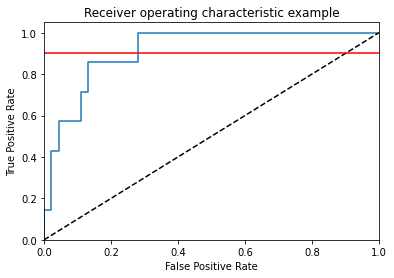

In [154]:
scores = np.argmax(recipe1_predict_label, axis =-1)
scores = np.array(list(map(lambda x : x[1], recipe1_predict_label)))
y = recipe1_true_label


scores = np.argmax(recipe1_predict_label, axis =-1)
scores = np.array(list(map(lambda x : x[1], metric1.pred_list)))
y = metric1.label_list

fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.axhline(0.9, c = 'r')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

In [152]:
fpr

array([0.        , 0.        , 0.01984127, 0.01984127, 0.04365079,
       0.04365079, 0.11111111, 0.11111111, 0.13095238, 0.13095238,
       0.28174603, 0.28174603, 1.        ])

In [153]:
tpr

array([0.        , 0.14285714, 0.14285714, 0.42857143, 0.42857143,
       0.57142857, 0.57142857, 0.71428571, 0.71428571, 0.85714286,
       0.85714286, 1.        , 1.        ])

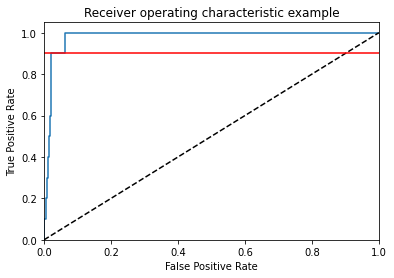

In [155]:
scores = np.argmax(recipe2_predict_label, axis =-1)
scores = np.array(list(map(lambda x : x[1], recipe2_predict_label)))
y = recipe2_true_label


scores = np.argmax(recipe2_predict_label, axis =-1)
scores = np.array(list(map(lambda x : x[1], metric2.pred_list)))
y = metric2.label_list

fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.axhline(0.9, c = 'r')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

In [145]:
fpr

array([0.        , 0.        , 0.        , 0.01386139, 0.01386139,
       0.01584158, 0.01584158, 0.02772277, 0.02772277, 0.02970297,
       0.02970297, 0.03366337, 0.03366337, 0.04752475, 0.04752475,
       0.05940594, 0.05940594, 1.        ])

In [146]:
tpr

array([0. , 0.1, 0.2, 0.2, 0.3, 0.3, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8,
       0.8, 0.9, 0.9, 1. , 1. ])

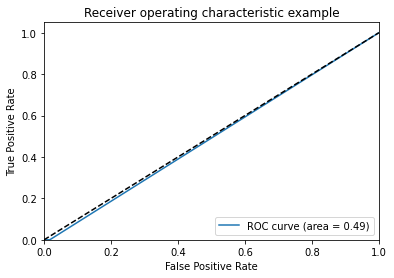

In [25]:
n = 5
'%.6f' % (0.001 *0.8 ** n)

'0.000328'